# Personalized Medicine: Redefining Cancer Treatment
https://www.kaggle.com/c/msk-redefining-cancer-treatment

## 1) Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import confusion_matrix
import scikitplot.plotters as skplt
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nikhil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2) Loading Datasets

In [3]:
# Loading training_variants
data_train_var = pd.read_csv('training_variants')
data_train_var.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
# Loading training_text
data_train_text = pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
data_train_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
# Loading test_variants
data_test_var = pd.read_csv('stage2_test_variants.csv')
data_test_var.head()
# Loading test_text
data_test_text = pd.read_csv('stage2_test_text.csv',sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
data_test_text.head()

,ID,TEXT
0,1,The incidence of breast cancer is increasing i...
1,2,An unselected series of 310 colorectal carcino...
2,3,Mycosis fungoides and SÃ©zary syndrome are pri...
3,4,Regulated progression through the cell cycle ...
4,5,Pilocytic astrocytoma (PA) is emerging as a tu...


In [6]:
# # Loading test_variants
# data_test_var = pd.read_csv('test_variants')
# data_test_var.head()
# # Loading test_text
# data_test_text = pd.read_csv('test_text',sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
# data_test_text.head()

Features and target attribute:
<li><b>ID : </b>row id</li>
<li><b>Gene : </b>gene of the genetic mutation</li>
<li><b>Variation : </b>variation of genetic mutation</li>
<li><b>Class :</b>class of the genetic mutation</li>

## 3) Exploring data

In [7]:
#shape of train_variants data
data_train_var.shape

(3321, 4)

In [8]:
#shape of train_variants data
data_test_var.shape

(986, 3)

In [9]:
# Features of train_variants
data_train_var.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

In [10]:
# Classes 
data_train_var.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [11]:
data_train_var.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [12]:
# Descriptive statistics
data_train_var.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [13]:
# How does text data of train_text look like
data_train_text["TEXT"][0]

"Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK1

In [14]:
len(data_train_text["TEXT"][0])

39765

In [15]:
len(data_train_text['TEXT'][0])

39765

Text data for very first row containt about Thirteen Nine thousands characters(length of the string)

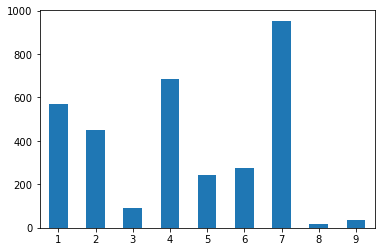

In [16]:
data_train_var['Class'].value_counts().sort_index().plot(kind="bar", rot=0)

Classes are very imbalanced

## 4) Data Cleaning and Preprocessing

In [17]:
# Checking null values
data_train_var[data_train_var.isnull().any(axis=1)]

,ID,Gene,Variation,Class


In [18]:
data_test_var[data_test_var.isnull().any(axis=1)]

,ID,Gene,Variation


In [19]:
data_train_var.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

In [20]:
data_train_text[data_train_text.isnull().any(axis=1)]

,ID,TEXT
1109,1109,NaN
1277,1277,NaN
1407,1407,NaN
1639,1639,NaN
2755,2755,NaN


In [21]:
data_train_text.isnull().sum()

ID      0
TEXT    5
dtype: int64

In [22]:
data_test_text.isnull().sum()

ID      0
TEXT    0
dtype: int64

There are 5 rows in train data and 1 row in test data with null values. 
We can either remove them completely or fill with some other value. Since we've to predict for 1 row in test data also, we can go with replacing null values with 'gene' + 'variation', while it might not be completely related to gene and variation but it can be a little related to them.

In [23]:
data_train_text.loc[data_train_text['TEXT'].isnull(),'TEXT'] = data_train_var['Gene'] +' ' + data_train_var['Variation']

In [24]:
# Verifying if any null values exit now
data_train_text.isnull().sum()

ID      0
TEXT    0
dtype: int64

In [25]:
data_test_text.loc[data_test_text['TEXT'].isnull(),'TEXT'] = data_test_var['Gene'] +' ' + data_test_var['Variation']

In [26]:
data_test_text.isnull().sum()

ID      0
TEXT    0
dtype: int64

We need to preprocess our data before feeding it to our model, because it may contain many special characters, numbers, multiple spaces, stop words, same words in upper and lower cases. So we can remove or replace because it'll not make sense for our model to learn from special characters, differntiating same words just because of lower and upper cases.

In [27]:
word_counts = data_train_text["TEXT"].apply(lambda x: len(x.split()))
word_counts.mean()

9542.507678410117

Average number of words in text data is almost 6857

In [28]:
# # data preprocessing including removing stop words
# def text_preprocessing(df):
    
#     for i in range(len(df)):
#         text_preprocess = df[i]
#         string = ""
#         text_preprocess = re.sub('[^a-zA-Z0-9\n]', ' ', str(text_preprocess))
#         # single space insted of multiple spaces
#         text_preprocess = re.sub('\s+',' ', str(text_preprocess))
#         text_preprocess = text_preprocess.lower()
        
#         for word in text_preprocess.split():
#             if not word in stop_words:
#                 string += word + " "
        
#         df[i] = string

In [29]:
# text_preprocessing(data_train_text['TEXT'])

In [30]:
# data_train_text

## 5) Merging datasets(variants and text)

In [31]:
# merging train data
data_train = pd.merge(data_train_var, data_train_text, how='left', on='ID')
data_train.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [32]:
# merging test data
data_test = pd.merge(data_test_var, data_test_text, how='left', on='ID')
data_test.head()

,ID,Gene,Variation,TEXT
0,1,CHEK2,H371Y,The incidence of breast cancer is increasing i...
1,2,AXIN2,Truncating Mutations,An unselected series of 310 colorectal carcino...
2,3,WNT4,E216G,Mycosis fungoides and SÃ©zary syndrome are pri...
3,4,SUCLA2,G118R,Regulated progression through the cell cycle ...
4,5,BRAF,T599insTT,Pilocytic astrocytoma (PA) is emerging as a tu...


In [33]:
y = data_train['Class']
data_train = data_train.drop('Class', axis='columns')

In [34]:
data_train.isnull().sum()

ID           0
Gene         0
Variation    0
TEXT         0
dtype: int64

## 6) Categorical variables into dummy variables

In [35]:
# for genes

In [36]:
gene_train_dummies = pd.get_dummies(data_train['Gene'])
gene_test_dummies = pd.get_dummies(data_test['Gene'])

In [37]:
gene_train_dummies, gene_test_dummies = gene_train_dummies.align(gene_test_dummies, join='left', axis=1)

In [38]:
# one_hot_gene = pd.get_dummies(df_train['Gene'])
svd_gene = TruncatedSVD(n_components=25, n_iter=20)
truncated_gene_train_dummies = svd_gene.fit_transform(gene_train_dummies)

In [39]:
gene_test_dummies.fillna(0, inplace = True)
truncated_gene_test_dummies = svd_gene.transform(gene_test_dummies)

In [40]:
# for variations

In [41]:
variation_train_dummies = pd.get_dummies(data_train['Variation'])
variation_test_dummies = pd.get_dummies(data_test['Variation'])

In [42]:
variation_train_dummies, variation_test_dummies = variation_train_dummies.align(variation_test_dummies, join='left', axis=1)

In [43]:
svd_variation = TruncatedSVD(n_components=50, n_iter=20)
truncated_variation_train_dummies = svd_variation.fit_transform(variation_train_dummies)

In [44]:
variation_test_dummies.fillna(0, inplace = True)
truncated_variation_test_dummies = svd_variation.transform(variation_test_dummies)

In [45]:
# Function to plot confusion matrix and calculte log loss and accuracy
def model_evaluation(X, y, clf=LogisticRegression()):
    
    y_probs = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=0), n_jobs=-1, method='predict_proba', verbose=3)
    indices_maxprob = np.argmax(y_probs, axis=1)
    classes = np.unique(y)
    y_preds = classes[indices_maxprob]
    print('Log loss: {}'.format(log_loss(y, y_probs)))
    print('Accuracy: {}'.format(accuracy_score(y, y_preds)))
    plt.figure(figsize=(20,7))
    cm = confusion_matrix(y, y_preds)
    sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=classes, yticklabels=classes)

In [46]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

## 7) bag-of-words model

In [47]:
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=LemmaTokenizer(),
    preprocessor=None, stop_words='english', max_features=None)  

In [48]:
bow_train = count_vectorizer.fit_transform(data_train['TEXT'])

C:\Users\Nikhil\anaconda3\envs\data-science\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [49]:
svd_bow = TruncatedSVD(n_components=100, n_iter=20)
truncated_train_bow = svd_bow.fit_transform(bow_train)

In [50]:
X_train_bow = np.hstack((truncated_gene_train_dummies, truncated_variation_train_dummies, truncated_train_bow))

C:\Users\Nikhil\anaconda3\envs\data-science\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   34.3s remaining:   51.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.3s finished


Log loss: 1.6329436937107198
Accuracy: 0.4188497440529961


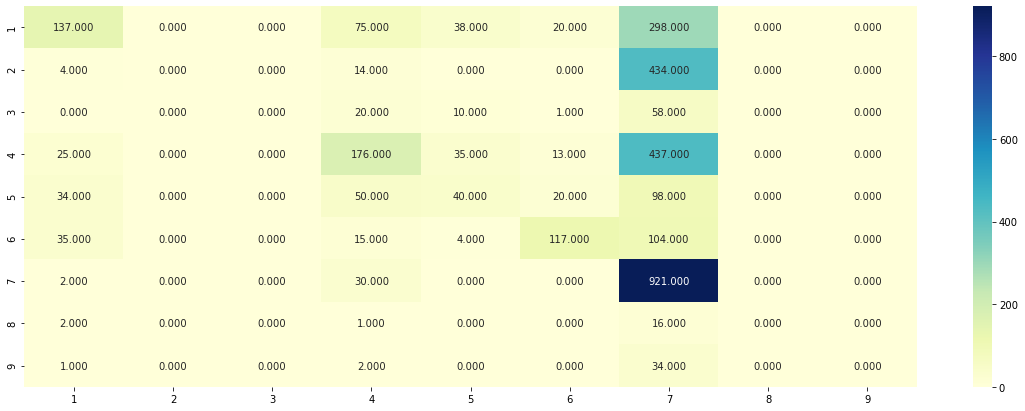

In [51]:
model_evaluation(X_train_bow, y, RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

We can use TfidfVectorizer which is better than Bag of Words.

## 8) TfidfVectorizer

In [52]:
count_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=LemmaTokenizer(),
    preprocessor=None, stop_words='english', max_features=None)    

tfidf_train = count_vectorizer.fit_transform(data_train['TEXT'])

C:\Users\Nikhil\anaconda3\envs\data-science\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [53]:
len(count_vectorizer.get_feature_names())

275447

In [54]:
svd_tfidf = TruncatedSVD(n_components=100, n_iter=20)
truncated_tfidf_train = svd_tfidf.fit_transform(tfidf_train)

In [55]:
X_tfidf_train = np.hstack((truncated_gene_train_dummies, truncated_variation_train_dummies, truncated_tfidf_train))

## 9) Hyperparameter Tuning

In [57]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto', probability = True),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'bootstrap': [True, False],
             'max_depth': [10, 30, 50, 70, 90, 100, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [100, 500, 1000, 1500, 1800, 2000]
        }
    },
    'xgboost' : {
        'model': XGBClassifier(),
        'params': {
            'n_estimators' : [100, 500, 900, 1100, 1500],
            'booster' : ['gbtree','gblinear'],
            'learning_rate' : [0.05,0.1,0.15,0.20]
        }
    }
}

In [58]:
scores = []

for model_name, mp in model_params.items():
    reg =  RandomizedSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False, scoring='neg_log_loss')
    reg.fit(X_tfidf_train, y)
    scores.append({
        'model': model_name,
        'best_score': reg.best_score_,
        'best_params': reg.best_params_,
        'best_estimator': reg.best_estimator_
    })
    
df_eval = pd.DataFrame(scores,columns=['model','best_score','best_params', 'best_estimator'])
df_eval

C:\Users\Nikhil\anaconda3\envs\data-science\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


,model,best_score,best_params,best_estimator
0,svm,-1.831767,"{'kernel': 'rbf', 'C': 1}","SVC(C=1, gamma='auto', probability=True)"
1,random_forest,-1.578462,"{'n_estimators': 2000, 'min_samples_split': 10...","(DecisionTreeClassifier(max_depth=70, max_feat..."
2,xgboost,-1.723320,"{'n_estimators': 100, 'learning_rate': 0.05, '...","XGBClassifier(base_score=0.5, booster='gbtree'..."


In [59]:
df_eval['best_params'][1]

{'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': True}

We're getting our best score for XGBClassifier with params as given below:

In [ ]:
# best_params = {{'n_estimators': 2000,'min_samples_split': 10,'min_samples_leaf': 4,'max_features': 'sqrt','max_depth': 70,'bootstrap': True}}

So we'll train our model using those hyperparamaters.

C:\Users\Nikhil\anaconda3\envs\data-science\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   16.0s remaining:   24.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.4s finished


Log loss: 1.7237787106484614
Accuracy: 0.41041854862993077


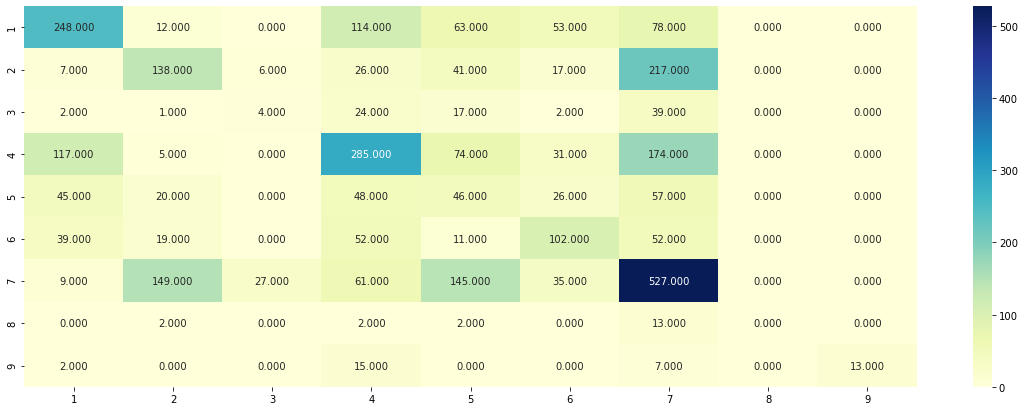

In [61]:
# LogisticRegression() model
model_evaluation(X_tfidf_train, y)

We got our best model is RandomForestClassifier

In [62]:
clf = RandomForestClassifier(n_estimators= 2000,min_samples_split= 10,min_samples_leaf= 4,max_features= 'sqrt',max_depth= 70,bootstrap= True)

C:\Users\Nikhil\anaconda3\envs\data-science\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Log loss: 1.5846372540706448
Accuracy: 0.43390545016561277


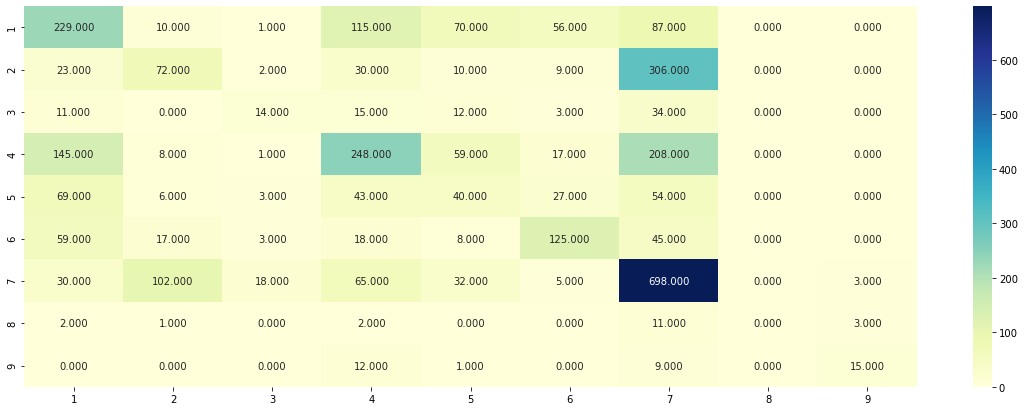

In [63]:
model_evaluation(X_tfidf_train, y, clf)

In [64]:
clf1 = RandomForestClassifier(n_estimators= 2000,min_samples_split= 10,min_samples_leaf= 4,max_features= 'sqrt',max_depth= 70,bootstrap= True)
clf1.fit(X_tfidf_train, y)

RandomForestClassifier(max_depth=70, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=2000)

In [65]:
y_train_pred = clf1.predict(X_tfidf_train)
y_true = y.ravel()

In [66]:
precision_score(y_true, y_train_pred, average = 'macro', zero_division = 1)

0.872947215205862

In [67]:
recall_score(y_true, y_train_pred, average = 'macro')

0.7148843666215102

## 10) Classifying test data

In [68]:
tfidf_test = count_vectorizer.transform(data_test['TEXT'])
truncated_tfidf_test = svd_tfidf.transform(tfidf_test)
X_tfidf_test = np.hstack((truncated_gene_test_dummies, truncated_variation_test_dummies, truncated_tfidf_test))

In [69]:
clf = XGBClassifier(n_estimators= 100, learning_rate= 0.05, booster= 'gbtree')
clf.fit(X_tfidf_train, y)
y_pred = clf.predict_proba(X_tfidf_test)

In [70]:
size = len(X_tfidf_test)

In [71]:
indices_maxprob = np.argmax(y_pred, axis=1)
y_test_probas = np.zeros((size, 9))
for i in range(size):
    y_test_probas[i][indices_maxprob[i]] = 1

In [72]:
ids = np.zeros((size, 1))
y_test_probas = np.hstack((ids, y_test_probas))

In [73]:
columns=['class'+str(c+1) for c in range(9)]
columns.insert(0, 'ID')

In [74]:
submission = pd.DataFrame(y_test_probas, columns=columns)
submission["ID"] = data_test['ID']
submission.head()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [75]:
submission.to_csv('submission.csv', index=False)

In [76]:
submission

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
981,982,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
982,983,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
983,984,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
984,985,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
